In [2]:
#import libraries, add additional libraries as needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import yeojohnson
from sklearn.feature_selection import f_classif, SelectKBest

In [3]:
## Data Cleaning - It involves identifying missing values, detecting outliers, handling inconsistencies if any

acc_data = pd.read_csv('data/US_Accidents_Stratified_Sample.csv')

acc_data_info = acc_data.info()
acc_data_head = acc_data.head()

acc_data_info, acc_data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77284 entries, 0 to 77283
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     77284 non-null  object 
 1   Source                 77284 non-null  object 
 2   Severity               77284 non-null  int64  
 3   Start_Time             77284 non-null  object 
 4   End_Time               77284 non-null  object 
 5   Start_Lat              77284 non-null  float64
 6   Start_Lng              77284 non-null  float64
 7   End_Lat                43356 non-null  float64
 8   End_Lng                43356 non-null  float64
 9   Distance(mi)           77284 non-null  float64
 10  Description            77284 non-null  object 
 11  Street                 77177 non-null  object 
 12  City                   77282 non-null  object 
 13  County                 77284 non-null  object 
 14  State                  77284 non-null  object 
 15  Zi

(None,
           ID   Source  Severity           Start_Time             End_Time  \
 0  A-3726992  Source1         2  2022-05-02 07:33:26  2022-05-02 08:48:28   
 1  A-1897039  Source2         2  2019-09-06 07:16:55  2019-09-06 08:16:43   
 2  A-5710019  Source1         2  2021-07-27 11:28:29  2021-07-27 13:26:15   
 3  A-7271253  Source1         2  2020-02-21 14:07:00  2020-02-21 15:20:21   
 4  A-6807168  Source1         2  2020-11-14 05:32:00  2020-11-14 08:09:14   
 
    Start_Lat   Start_Lng    End_Lat     End_Lng  Distance(mi)  ... Roundabout  \
 0  37.403823  -77.424978  37.431753  -77.431268         1.960  ...      False   
 1  33.572609  -81.774269        NaN         NaN         0.000  ...      False   
 2  31.759168 -106.355764  31.762187 -106.360597         0.352  ...      False   
 3  43.947930  -92.042720  43.947930  -92.042720         0.000  ...      False   
 4  38.363234 -122.721242  38.363237 -122.725248         0.217  ...      False   
 
   Station   Stop Traffic_Cal

#Data Cleaning

In [4]:
# Converting 'Start_Time' and 'End_Time' to datetime objects
acc_data['Start_Time'] = pd.to_datetime(acc_data['Start_Time'])
acc_data['End_Time'] = pd.to_datetime(acc_data['End_Time'])

# Handling Missing values - Imputing missing numerical data with median for coordinates and mean for other columns
num_columns = acc_data.select_dtypes(include=['float64', 'int64']).columns
loc_coordinates = ['End_Lat', 'End_Lng']  # Coordinates to be imputed with median
for column in num_columns:
    if column in loc_coordinates:
        imputer = SimpleImputer(strategy='median')
    else:
        imputer = SimpleImputer(strategy='mean')
    acc_data[column] = imputer.fit_transform(acc_data[[column]])

# Imputing missing categorical data with the most frequent value
categorical_columns = acc_data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    acc_data[column].fillna(acc_data[column].mode()[0], inplace=True)

# Handling Outliers in Distance(mi) column using the IQR method
Q1_distance = acc_data['Distance(mi)'].quantile(0.25)
Q3_distance = acc_data['Distance(mi)'].quantile(0.75)
IQR_distance = Q3_distance - Q1_distance
lower_bound_distance = Q1_distance - 1.5 * IQR_distance
upper_bound_distance = Q3_distance + 1.5 * IQR_distance
acc_data = acc_data[~((acc_data['Distance(mi)'] < lower_bound_distance) | (acc_data['Distance(mi)'] > upper_bound_distance))]

# Confirming that there are no missing values left
missing_values_final = acc_data.isnull().sum()
missing_values_final_all = all(missing_values_final == 0)

print(acc_data.shape)

print(missing_values_final_all)
acc_data.head()


(67553, 46)
True


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
1,A-1897039,Source2,2.0,2019-09-06 07:16:55,2019-09-06 08:16:43,33.572609,-81.774269,36.234020,-88.101163,0.000,...,False,False,False,False,False,False,Day,Day,Day,Day
2,A-5710019,Source1,2.0,2021-07-27 11:28:29,2021-07-27 13:26:15,31.759168,-106.355764,31.762187,-106.360597,0.352,...,False,False,False,False,False,False,Day,Day,Day,Day
3,A-7271253,Source1,2.0,2020-02-21 14:07:00,2020-02-21 15:20:21,43.947930,-92.042720,43.947930,-92.042720,0.000,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6807168,Source1,2.0,2020-11-14 05:32:00,2020-11-14 08:09:14,38.363234,-122.721242,38.363237,-122.725248,0.217,...,False,False,False,False,False,False,Night,Night,Night,Day
5,A-6007817,Source1,2.0,2021-11-19 15:46:41,2021-11-19 20:51:57,30.394799,-97.653814,30.386103,-97.649023,0.665,...,False,False,False,False,False,False,Day,Day,Day,Day


In [5]:
# Now that the data is cleaned, we proceed with scaling the numerical features
# We are excluding the 'Severity' column as we are taking it as the target variable

# Exclude 'Severity' for scaling
numeric_columns = acc_data.select_dtypes(include=['int64', 'float64']).columns.drop('Severity')

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the numeric columns and transform the data
acc_data[numeric_columns] = scaler.fit_transform(acc_data[numeric_columns])

acc_data[numeric_columns].head()


,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
1,0.369691,0.755931,0.479494,0.643867,0.000000,0.578818,0.718056,0.877551,0.949003,0.111111,0.000000,0.000881
2,0.295167,0.320542,0.295548,0.320454,0.307424,0.689655,0.826035,0.357143,0.847663,0.111111,0.000000,0.000881
3,0.796072,0.574055,0.796802,0.574054,0.000000,0.381773,0.484103,0.591837,0.953253,0.111111,0.106667,0.000000
4,0.566565,0.030676,0.567079,0.030602,0.189520,0.381773,0.526095,1.000000,0.973521,0.011111,0.000000,0.000000
5,0.239097,0.474671,0.238943,0.474754,0.580786,0.566502,0.706059,0.224490,0.956195,0.111111,0.000000,0.000000


In [6]:
#Handling Skewed Data Distributions

# Identify numeric columns from the dataset except 'Severity' column as it is the target variable
numeric_columns = acc_data.select_dtypes(include=['int64', 'float64']).columns.drop('Severity')

# Calculating the skewness for each numeric column
skewness = acc_data[numeric_columns].skew().sort_values(ascending=False)

# Identifying columns with skewness outside the range -0.5 to 0.5
skewed_columns = skewness[abs(skewness) > 0.5].index.tolist()

# Applying Yeo-Johnson transformation - The Yeo-Johnson transformation can handle both positive and negative values
for col in skewed_columns:
    acc_data[col], _ = yeojohnson(acc_data[col])

#Checking the skewness after Yeo-Johnson transformation
transformed_skewness_yeojohnson = acc_data[skewed_columns].skew()

transformed_skewness_yeojohnson


Precipitation(in)    1.167315
Visibility(mi)      -0.112870
Distance(mi)         0.761960
Wind_Speed(mph)      0.000216
Temperature(F)      -0.042045
Wind_Chill(F)        0.016831
End_Lng             -0.242969
Pressure(in)        -0.307077
dtype: float64

#Exploratory Data Analysis (EDA)

In [7]:
# Displaying Descriptive statistics for the dataset
descriptive_statistics = acc_data.describe(include='all', datetime_is_numeric=True)

descriptive_statistics

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
count,67553,67553,67553.000000,67553,67553,67553.000000,67553.000000,67553.000000,67553.000000,67553.000000,...,67553,67553,67553,67553,67553,67553,67553,67553,67553,67553
unique,67553,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,2,2,1,2,2,2,2
top,A-1897039,Source1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day
freq,1,34988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67550,65565,65501,67483,56381,67553,46972,50084,53445,56101
mean,NaN,NaN,2.211123,2020-04-13 22:21:15.925954304,2020-04-14 02:49:57.596162304,0.471589,0.522929,0.475797,1.765912,0.044895,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,2016-02-09 07:15:41,2016-02-09 07:45:41,0.000000,0.000000,0.000000,0.000000,-0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2.000000,2018-09-28 05:31:26,2018-09-28 05:59:39,0.353117,0.127125,0.454479,1.586778,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2.000000,2020-08-05 22:50:23,2020-08-06 08:50:04,0.452177,0.646517,0.479494,1.876826,0.007628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2.000000,2021-12-09 15:59:32,2021-12-09 19:06:40,0.632488,0.779932,0.479494,1.915498,0.098781,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,4.000000,2023-03-31 20:16:30,2023-03-31 21:57:43,1.000000,1.000000,1.000000,4.878084,0.147915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


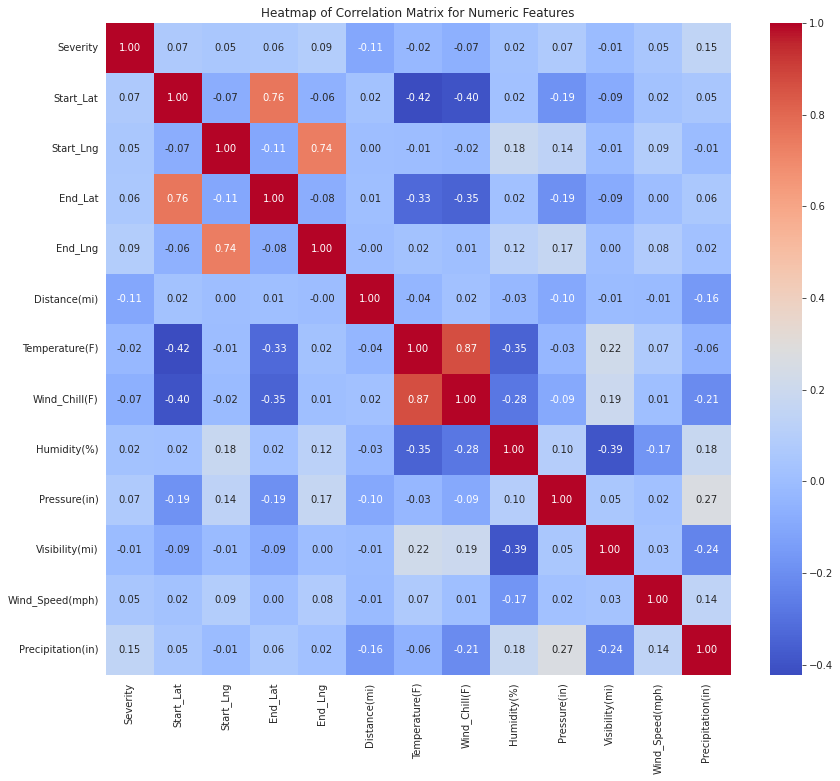

In [8]:
# Correlation Analysis
# Calculate the correlation matrix for numerical features
numeric_data = acc_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

# Plotting the Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Correlation Matrix for Numeric Features')
plt.show()


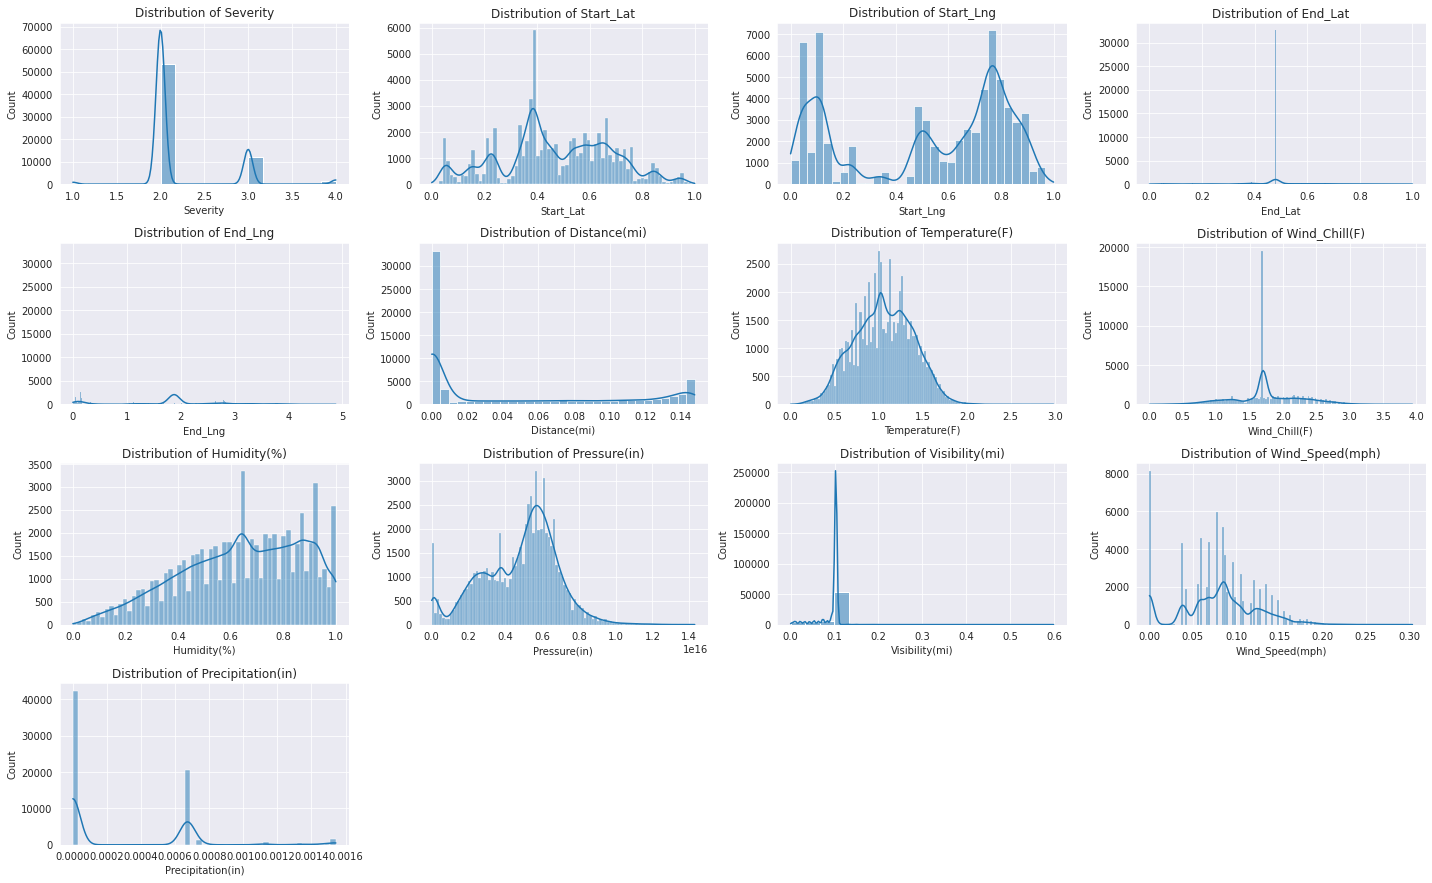

In [9]:
# Visualization of distributions and relationships
#Plotting histograms, scatter plots, box plots to understand distributions and relationships in the data

# Histograms for all numeric features
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_data.columns):
    plt.subplot(5, 4, i + 1)
    sns.histplot(numeric_data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

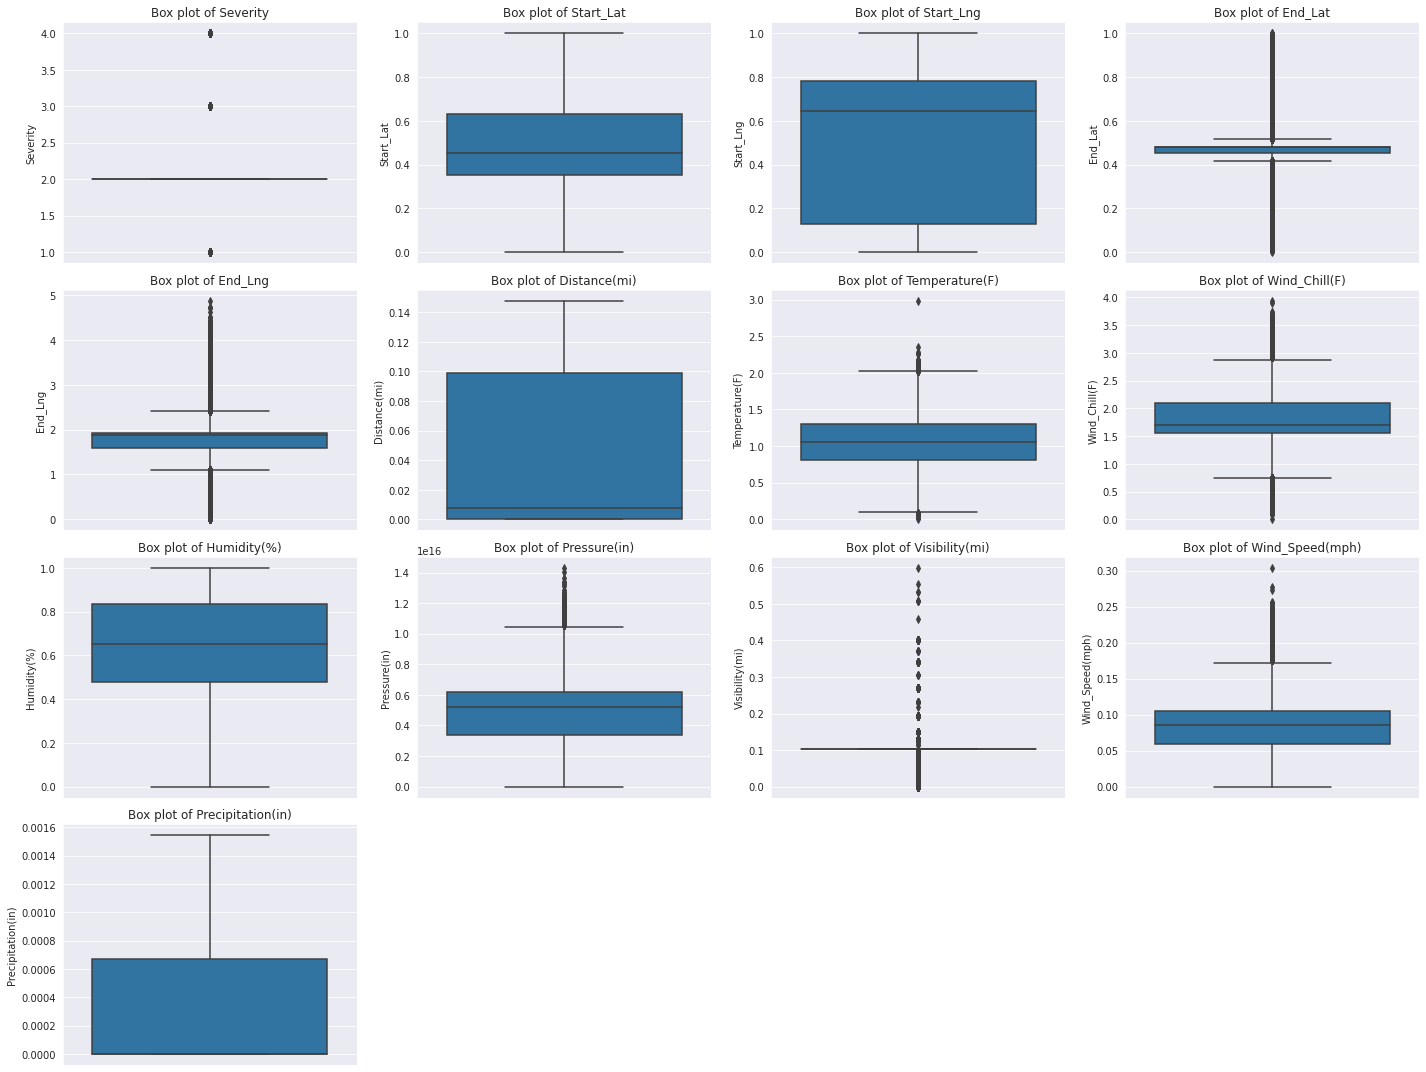

In [10]:
# Box plots to check for outliers in numeric data
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_data.columns):
    plt.subplot((len(numeric_data.columns) - 1) // 4 + 1, 4, i + 1)
    sns.boxplot(y=numeric_data[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

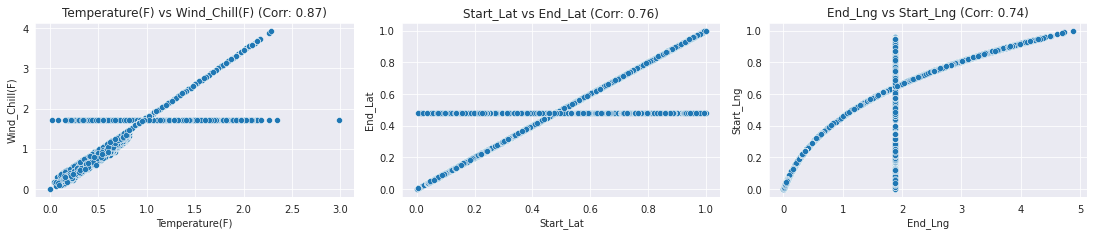

In [11]:
# Scatter plots for pairs of features with strong correlations

# Plotting top pairs of correlated features
plt.figure(figsize=(20, 15))
corr_pairs = correlation_matrix.unstack().sort_values(kind="quicksort", ascending=False)
strong_pairs = corr_pairs[abs(corr_pairs) > 0.5].drop_duplicates()

for i, ((feature1, feature2), corr_value) in enumerate(strong_pairs.items()):
    if feature1 != feature2:  # Exclude self-correlation
        plt.subplot(5, 4, i + 1)
        sns.scatterplot(data=numeric_data, x=feature1, y=feature2)
        plt.title(f'{feature1} vs {feature2} (Corr: {corr_value:.2f})')
        if i >= 19:
            break
plt.tight_layout()
plt.show()


#Baseline Model

In [12]:
#Feature Selection using ANOVA

# Preparing the feature set for feature selection, excluding non-numeric columns and datetime columns
X = acc_data.select_dtypes(include=[np.number]).drop(columns=['Severity'])
y = acc_data['Severity']

# ANOVA F-value selection
selector_f_classif = SelectKBest(score_func=f_classif, k=10)
X_new_f_classif = selector_f_classif.fit(X, y)
anova_results = pd.DataFrame({
    'Feature': X.columns,
    'F Score': X_new_f_classif.scores_,
    'P Value': X_new_f_classif.pvalues_
})
anova_results_sorted = anova_results.sort_values(by='F Score', ascending=False).reset_index(drop=True)

# Show top 10 features based on ANOVA F-value
anova_results_sorted.head(10)

,Feature,F Score,P Value
0,Distance(mi),2022.932320,0.000000e+00
1,Precipitation(in),728.339205,0.000000e+00
2,Pressure(in),222.909174,6.528689e-144
3,End_Lng,210.950491,3.304073e-136
4,Wind_Chill(F),176.993701,2.590179e-114
5,Start_Lat,111.492112,5.163710e-72
6,End_Lat,108.539429,4.181630e-70
7,Start_Lng,93.617995,1.847518e-60
8,Temperature(F),88.867383,2.176026e-57
9,Wind_Speed(mph),84.254027,2.089509e-54


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Let's assume the top 10 features are stored in a list called top_feature_names.
top_features = ['Distance(mi)', 'Precipitation(in)', 'Pressure(in)', 'End_Lng', 'Wind_Chill(F)',
                     'Start_Lat', 'End_Lat', 'Start_Lng', 'Temperature(F)', 'Wind_Speed(mph)']

X = acc_data[top_features]
y = acc_data['Severity']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the logistic regression model
log_reg_model = LogisticRegression(max_iter=10000, class_weight='balanced')

# Fit the model to the training data
log_reg_model.fit(X_train, y_train)

# Predicting on the test data
y_pred = log_reg_model.predict(X_test)

# Evaluating the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       124
         2.0       0.00      0.00      0.00     10629
         3.0       0.18      1.00      0.31      2478
         4.0       0.00      0.00      0.00       280

    accuracy                           0.18     13511
   macro avg       0.05      0.25      0.08     13511
weighted avg       0.03      0.18      0.06     13511

[[    0     0   124     0]
 [    0     0 10629     0]
 [    0     0  2478     0]
 [    0     0   280     0]]


/home/jdwolfe/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jdwolfe/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jdwolfe/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
from sklearn.ensemble import RandomForestClassifier

# The n_estimators parameter specifies the number of trees in the forest of the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
classification_rep_rf = classification_report(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print(classification_rep_rf)
print(conf_matrix_rf)


              precision    recall  f1-score   support

           1       0.81      0.89      0.85      4049
           2       0.61      0.41      0.49      3962
           3       0.66      0.65      0.66      3990
           4       0.65      0.81      0.72      3964

    accuracy                           0.69     15965
   macro avg       0.68      0.69      0.68     15965
weighted avg       0.68      0.69      0.68     15965

[[3601   86  263   99]
 [ 356 1605  922 1079]
 [ 422  423 2610  535]
 [  56  515  166 3227]]


Let us look at the distribution of severity values to see if there is a class imbalance that is affecting the accuracies of the models above

In [36]:
class_distribution = acc_data['Severity'].value_counts()

# Calculate distribution precentage
class_distribution_percent = acc_data['Severity'].value_counts(normalize=True) * 100

# Printing the results
print("Class Distribution Count:\n", class_distribution)
print("\nClass Distribution Percentage:\n", class_distribution_percent)


Class Distribution Count:
 2.0    53434
3.0    12035
4.0     1437
1.0      647
Name: Severity, dtype: int64

Class Distribution Percentage:
 2.0    79.099374
3.0    17.815641
4.0     2.127219
1.0     0.957766
Name: Severity, dtype: float64


In [37]:
# Load in balanced dataset and check class distributions

data_balanced = pd.read_csv('data/US_Accidents_Balanced_Sample.csv')

class_distribution = data_balanced['Severity'].value_counts()
class_distribution_percent = data_balanced['Severity'].value_counts(normalize=True) * 100

# Printing the results
print("Class Distribution Count:\n", class_distribution)
print("\nClass Distribution Percentage:\n", class_distribution_percent)

Class Distribution Count:
 3    20000
4    20000
1    20000
2    20000
Name: Severity, dtype: int64

Class Distribution Percentage:
 3    25.0
4    25.0
1    25.0
2    25.0
Name: Severity, dtype: float64


In [38]:
# Lets remove some unnecesary columns from our balanced dataset

column_list = data_balanced.columns
print(column_list)

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


In [39]:
# List of column to drop
columns_to_drop = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
                   'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
                   'Turning_Loop', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
                   'Description', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
                   'ID', 'Source', 'End_Lat', 'End_Lng', 'Street', 'City', 'County',
                   'State', 'Wind_Chill(F)', 'Wind_Direction', 'Wind_Speed(mph)', 'End_Time', 'Zipcode']

In [40]:

# taking a copy df to use for an arima model later
arima_data_df = data_balanced.copy()
arima_data_df['Start_Time'] = pd.to_datetime(arima_data_df['Start_Time'])
arima_data_df['End_Time'] = pd.to_datetime(arima_data_df['End_Time'])
arima_data_df['Month'] = arima_data_df['Start_Time'].dt.to_period('M')
arima_data_df['Week'] = arima_data_df['Start_Time'].dt.to_period('W')


# Drop columns
data_balanced = data_balanced.drop(columns=columns_to_drop)

# Convert 'Sunrise_Sunset' to a numerical column
data_balanced['Sunrise_Sunset'] = data_balanced['Sunrise_Sunset'].map({'Day': 1, 'Night': 0})

# Convert 'Start_Time' to date/time format
data_balanced['Start_Time'] = pd.to_datetime(data_balanced['Start_Time'])

# Extract time features from 'Start_Time'
data_balanced['hour_of_day'] = data_balanced['Start_Time'].dt.hour
data_balanced['day_of_week'] = data_balanced['Start_Time'].dt.dayofweek
data_balanced['month'] = data_balanced['Start_Time'].dt.month


# Drop the original 'Start_Time' column
data_balanced = data_balanced.drop(columns=['Start_Time'])

In [41]:
column_list = data_balanced.columns
print(column_list)

Index(['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Precipitation(in)',
       'Weather_Condition', 'Sunrise_Sunset', 'hour_of_day', 'day_of_week',
       'month'],
      dtype='object')


In [42]:
# Check for null values in each column
null_values = data_balanced.isnull().sum()

# Print the count of null values for each column
print(null_values)


Severity                 0
Start_Lat                0
Start_Lng                0
Distance(mi)             0
Temperature(F)           0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Precipitation(in)    21758
Weather_Condition      176
Sunrise_Sunset           0
hour_of_day              0
day_of_week              0
month                    0
dtype: int64


In [43]:
# Remove rows where 'Weather_Condition' is null
data_balanced = data_balanced.dropna(subset=['Weather_Condition'])

# Replace null values in 'Precipitation(in)' with zero
data_balanced['Precipitation(in)'] = data_balanced['Precipitation(in)'].fillna(0)

# Check for null values in each column
null_values = data_balanced.isnull().sum()

# Print the count of null values for each column
print(null_values)

Severity             0
Start_Lat            0
Start_Lng            0
Distance(mi)         0
Temperature(F)       0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Precipitation(in)    0
Weather_Condition    0
Sunrise_Sunset       0
hour_of_day          0
day_of_week          0
month                0
dtype: int64


In [44]:
data_balanced.dtypes

Severity               int64
Start_Lat            float64
Start_Lng            float64
Distance(mi)         float64
Temperature(F)       float64
Humidity(%)          float64
Pressure(in)         float64
Visibility(mi)       float64
Precipitation(in)    float64
Weather_Condition     object
Sunrise_Sunset         int64
hour_of_day            int64
day_of_week            int64
month                  int64
dtype: object

We need to ensure all features are numerical prior to building ML model. Let us encode the 'Weather_Condition' 

In [45]:
# Get unique values in 'Weather_Condition'
unique_weather_conditions = data_balanced['Weather_Condition'].unique()

# Count of unique weather conditions
num_unique_weather_conditions = data_balanced['Weather_Condition'].nunique()

# Print the unique values and their count
print("Unique Weather Conditions:", unique_weather_conditions)
print("Number of Unique Weather Conditions:", num_unique_weather_conditions)

Unique Weather Conditions: ['Fair' 'Partly Cloudy' 'Cloudy' 'Overcast' 'Clear' 'Scattered Clouds'
 'Rain / Windy' 'Mostly Cloudy' 'Light Rain' 'Haze' 'Rain' 'Thunder'
 'Light Snow' 'Light Drizzle' 'Heavy Rain' 'Partly Cloudy / Windy'
 'Light Rain with Thunder' 'Drizzle' 'Mostly Cloudy / Windy'
 'Cloudy / Windy' 'Mist' 'Fog' 'Snow' 'Heavy Drizzle' 'Light Freezing Fog'
 'Smoke' 'Fair / Windy' 'Thunder in the Vicinity' 'Heavy T-Storm'
 'Wintry Mix' 'Light Rain / Windy' 'N/A Precipitation' 'T-Storm'
 'Heavy Thunderstorms and Rain' 'Light Thunderstorms and Rain'
 'Heavy Snow' 'Patches of Fog' 'Light Rain Shower'
 'Showers in the Vicinity' 'Heavy T-Storm / Windy'
 'Sand / Dust Whirlwinds' 'Light Freezing Rain' 'Drizzle and Fog'
 'Light Snow / Windy' 'Sleet' 'Thunderstorm' 'Snow / Windy' 'Haze / Windy'
 'Freezing Rain' 'Blowing Snow / Windy' 'Thunderstorms and Rain'
 'Light Drizzle / Windy' 'Shallow Fog' 'Light Ice Pellets' 'Light Sleet'
 'Light Freezing Drizzle' 'Thunder / Windy' 'Heavy Snow

Many more weather conditions than expected. Will take a nuanced approach to account for such variability while inlcuding as much info as possible as it is believed weather conditions may hold a lot of influence on accident severity

In [46]:
# First lets have a basic weather categorization mapping

import re   # For Regular Expressions

def categorize_weather(condition):
    if re.search(r'(Snow|Ice|Sleet|Freezing|Blizzard|Small Hail)', condition, re.IGNORECASE):
        return 'Snow/Ice'
    elif re.search(r'(Rain|Drizzle|Showers|Thunder|T-Storm|Thunderstorm|Thunder in the Vicinity|Wintry Mix|N/A Precipitation|Tornado|Squalls)', condition, re.IGNORECASE):
        return 'Rain/Thunder'
    elif re.search(r'(Fog|Haze|Mist|Sand|Dust|Smoke)', condition, re.IGNORECASE):
        return 'Low Visibility'
    elif re.search(r'(Clear|Fair)', condition, re.IGNORECASE):
        return 'Clear'
    elif re.search(r'(Cloudy|Overcast|Scattered Clouds|Partly Cloudy)', condition, re.IGNORECASE):
        return 'Cloudy'
    else:
        return 'Other'

data_balanced['Simple_Weather_Condition'] = data_balanced['Weather_Condition'].apply(categorize_weather)



In [47]:
# Create a binary feature for 'Extreme' conditions
extreme_keywords = ['Heavy T-Storm', 'Tornado', 'Small Hail', 'Thunder and Hail', 'Squalls']
pattern = '|'.join(extreme_keywords)
data_balanced['Is_Extreme'] = data_balanced['Weather_Condition'].str.contains(pattern, case=False, na=False).astype(int)

In [48]:
# Lets create a binary feature for 'Windy' condition too
data_balanced['Is_Windy'] = data_balanced['Weather_Condition'].str.contains('Windy', case=False, na=False).astype(int)

In [49]:
# Below code was used to iteratively determine logic for categorize_weather() to ensure all weather conditions are accounted for

# Find unique weather conditions categorized as 'Other'
other_conditions = data_balanced[data_balanced['Simple_Weather_Condition'] == 'Other']['Weather_Condition'].unique()

# Print the conditions categorized as 'Other'
print("Unique Weather Conditions categorized as 'Other':", other_conditions)


Unique Weather Conditions categorized as 'Other': []


In [50]:
column_list = data_balanced.columns
print(column_list)

Index(['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Precipitation(in)',
       'Weather_Condition', 'Sunrise_Sunset', 'hour_of_day', 'day_of_week',
       'month', 'Simple_Weather_Condition', 'Is_Extreme', 'Is_Windy'],
      dtype='object')


In [51]:
# Remove 'Weather_Condition' column as info is accounted for in newly created features
data_balanced = data_balanced.drop('Weather_Condition', axis=1)

In [52]:
# Perform one-hot encoding of 'Simple_Weather_Condition'
weather_encoded = pd.get_dummies(data_balanced['Simple_Weather_Condition'], prefix='Weather')
data_balanced = pd.concat([data_balanced, weather_encoded], axis=1)
data_balanced = data_balanced.drop('Simple_Weather_Condition', axis=1)

In [53]:
# All features are now numeric and appropriately encoded
data_balanced.dtypes

Severity                    int64
Start_Lat                 float64
Start_Lng                 float64
Distance(mi)              float64
Temperature(F)            float64
Humidity(%)               float64
Pressure(in)              float64
Visibility(mi)            float64
Precipitation(in)         float64
Sunrise_Sunset              int64
hour_of_day                 int64
day_of_week                 int64
month                       int64
Is_Extreme                  int64
Is_Windy                    int64
Weather_Clear               uint8
Weather_Cloudy              uint8
Weather_Low Visibility      uint8
Weather_Rain/Thunder        uint8
Weather_Snow/Ice            uint8
dtype: object

#Time to try out a random forest with these features and compare with results of previous random forest

In [54]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define features and target
X = data_balanced.drop('Severity', axis=1)
y = data_balanced['Severity']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [55]:
print('\nCurrent model results:\n')
print(classification_rep)
print(conf_matrix)


Current model results:

              precision    recall  f1-score   support

           1       0.81      0.89      0.85      4049
           2       0.61      0.41      0.49      3962
           3       0.66      0.65      0.66      3990
           4       0.65      0.81      0.72      3964

    accuracy                           0.69     15965
   macro avg       0.68      0.69      0.68     15965
weighted avg       0.68      0.69      0.68     15965

[[3601   86  263   99]
 [ 356 1605  922 1079]
 [ 422  423 2610  535]
 [  56  515  166 3227]]


In [56]:
print('\nPrevious model results:\n')
print(classification_rep_rf)
print(conf_matrix_rf)


Previous model results:

              precision    recall  f1-score   support

           1       0.81      0.89      0.85      4049
           2       0.61      0.41      0.49      3962
           3       0.66      0.65      0.66      3990
           4       0.65      0.81      0.72      3964

    accuracy                           0.69     15965
   macro avg       0.68      0.69      0.68     15965
weighted avg       0.68      0.69      0.68     15965

[[3601   86  263   99]
 [ 356 1605  922 1079]
 [ 422  423 2610  535]
 [  56  515  166 3227]]


# Now lets train the random forest with cross validation and compare the results to the above

In [57]:
# Define features and target
X = data_balanced.drop('Severity', axis=1)
y = data_balanced['Severity']

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')

# Calculate average performance across all folds
average_score = np.mean(scores)

print("Cross-Validation Scores:", scores)
print("Average Cross-Validation Score:", average_score)

Cross-Validation Scores: [0.69188851 0.69959286 0.69057313 0.68694018 0.68861188]
Average Cross-Validation Score: 0.691521310515211


# Cross validation results show that model has consistent perfomance across different subsets of the data. Should generalize well to new data

## Gradient Boosting Classification Modeling

In [58]:

from sklearn.ensemble import GradientBoostingClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

gradient_booster = GradientBoostingClassifier(n_estimators=100, learning_rate=.05, max_depth=2, random_state=50)

gradient_booster.fit(X_train, y_train)

y_pred = gradient_booster.predict(X_test)

# Perform cross-validation and display the scores
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


print(classification_rep)
print(conf_matrix)

              precision    recall  f1-score   support

           1       0.67      0.87      0.76      4074
           2       0.60      0.25      0.35      3938
           3       0.61      0.54      0.57      3967
           4       0.60      0.83      0.70      3986

    accuracy                           0.63     15965
   macro avg       0.62      0.62      0.60     15965
weighted avg       0.62      0.63      0.60     15965

[[3555   47  239  233]
 [ 579  979 1016 1364]
 [1017  187 2151  612]
 [ 120  424  114 3328]]


## Parameter Tuning for the Gradient Boost Model

In [78]:
# Lets try to adjust the learning rate and max dept values to try to increase accuracy
from sklearn.model_selection import GridSearchCV
learning_rates = [ .1, .15, .2, .25]
max_dept = [3,4,5]
param_grid = {
    'learning_rate': learning_rates,
    'max_depth': max_dept
}

gradient_booster = GradientBoostingClassifier(n_estimators=100,random_state=50)
search = GridSearchCV(estimator=gradient_booster,
                      param_grid=param_grid,
                      scoring='accuracy',
                      n_jobs=-1)

search.fit(X_train,y_train)

display(f'Highest Learning Rate: {search.best_params_["learning_rate"]}')
display(f'Highest Max Dept {search.best_params_["max_depth"]}')



'Highest Learning Rate: 0.25'

'Highest Max Dept 5'

In [80]:
from sklearn.model_selection import GridSearchCV
learning_rates = [ .25, .3, .35, .5]
max_dept = [5,6,7,8]
param_grid = {
    'learning_rate': learning_rates,
    'max_depth': max_dept
}

gradient_booster = GradientBoostingClassifier(n_estimators=100,random_state=50)
search = GridSearchCV(estimator=gradient_booster,
                      param_grid=param_grid,
                      scoring='accuracy',
                      n_jobs=-1)

search.fit(X_train,y_train)

display(f'Highest Learning Rate: {search.best_params_["learning_rate"]}')
display(f'Highest Max Dept {search.best_params_["max_depth"]}')

'Highest Learning Rate: 0.25'

'Highest Max Dept 8'

In [81]:
#retry with tuned parameters

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

gradient_booster = GradientBoostingClassifier(n_estimators=100, learning_rate=.25, max_depth=8, random_state=50)

gradient_booster.fit(X_train, y_train)

y_pred = gradient_booster.predict(X_test)

# Perform cross-validation and display the scores
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


print(classification_rep)
print(conf_matrix)

              precision    recall  f1-score   support

           1       0.80      0.88      0.84      4074
           2       0.64      0.50      0.56      3938
           3       0.68      0.66      0.67      3967
           4       0.68      0.78      0.73      3986

    accuracy                           0.71     15965
   macro avg       0.70      0.71      0.70     15965
weighted avg       0.70      0.71      0.70     15965

[[3583  128  240  123]
 [ 367 1983  753  835]
 [ 439  422 2628  478]
 [  79  564  231 3112]]


## Support Vector Machine for Classification

In [ ]:
# show the coorelation heatmap again
from sklearn import svm
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

svm_model = svm.SVC(kernel='poly', degree=4)
svm_model.fit(X_train, y_train)
svm_predictor = svm_model.predict(X_test)
accuracy_score = accuracy_score(y_test, svm_predictor)
print(f'4th Degree polynomial Kernel Accuracy {accuracy_score}')

In [ ]:
# lets try to increase the accuracy of this SVM Model by hyperthermic tuning

# svm_tuning = {
#     'kernel': ['poly'],
#     'degree': [3,4,5]
# }
#
# svm_tuning_model = svm.SVC()
#
# grid_search_svm = GridSearchCV(estimator=svm_tuning_model,
#                                param_grid=svm_tuning,
#                                cv=5,
#                                scoring='accuracy',
#                                n_jobs=-1)
# grid_search_svm.fit(X_train, y_train)
#
# display(f'Best Degree Value {grid_search_svm.best_params_["degree"]}')
# display(f'Best Degree Value {grid_search_svm.best_params_["C"]}')